In [35]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
API_TOKEN = os.environ.get("MPTOKEN")
# print(API_TOKEN)

In [3]:
## Read our candidates file and get the mp-ids

CANDIDATE_IDS = []
with open('../TMR_Data.json') as fo:
    data = json.load(fo)

for material in data['candidates']:
    CANDIDATE_IDS.append(material['material_id'])

print(CANDIDATE_IDS[:5])


['mp-1013531', 'mp-1018710', 'mp-1019273', 'mp-1025517', 'mp-1029257']


In [4]:
mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': CANDIDATE_IDS},
}
prt = ['material_id', 'pretty_formula', 'icsd_ids', 'cif', 'elasticity']

cif_candidates = mpr.query(criteria=crt, properties=prt)



100%|██████████| 1934/1934 [00:12<00:00, 159.72it/s]


### Generate CIF files for the candidates

In [7]:
## Use 20 materials
ID_PROPS_DATA = []
count = 1
for i in cif_candidates:
    if i['elasticity'] is not None:
        print(f"processing {i['pretty_formula']}")
        
        ## Create CIF files from
        mat_name = f"{i['pretty_formula']}_{i['material_id']}"
        bulk_modulus = i['elasticity']['K_VRH']

        with open(f"data/{mat_name}.cif", 'w') as ff: 
            ff.write(i['cif'])
        
        ## Create csv data
        ID_PROPS_DATA.append([mat_name, bulk_modulus])
        
        # break
        count+=1

        # if count >= 20: break

with open("data/id_prop.csv", 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)


print(count)


processing Ba3BiN
processing Ba3BiN
processing Ti2ZnN
processing Hf3ZnN
processing Ti3ZnN
processing CdCo3N
processing CdNi3N
processing CuNi3N
processing Lu3AlN
processing Ni3SnN
processing Tm3AlN
processing HfTa2N3
processing Mn3PdN
processing U2CrN3
processing Ti2InN
processing Ti2GaN
processing LiRuN
processing Zn2ReN3
processing Ca(ZnN)2
processing CaZrN2
processing Zn2MoN3
processing CsVN2
processing LiSn2N3
processing Na2HfN2
processing RbVN2
processing NaRuN
processing Na2ZrN2
processing KZnN
processing LiV2N3
processing KPtN
processing NaZnN
processing CaHfN2
processing BaTiN2
processing LiCrN2
processing NaCrN2
processing RbCoN
processing KCoN
processing Li5OsN4
processing Ba(CoN)2
processing Zn2CrN3
processing NaNiN
processing ZnSnN2
processing Ca(InN)2
processing CsCoN
processing Mg2CrN3
processing Sr3ReN3
processing Ca2CoN2
processing Ca2CrN3
processing Ba3GaN3
processing Na5OsN4
processing Sr4ZrN4
processing Na3OsN2
processing Ca3CoN3
processing Ba3OsN3
processing Sr3WN3


## Train the model

In [27]:

ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

main_file = os.path.join(ROOT_DIR, "CLONES/cgcnn/main.py")
data_file = os.path.join(ROOT_DIR, "utils/data")

run_options = "--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
print(cmd)

result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
print(result.stdout.decode("utf-8"))

python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\CLONES/cgcnn/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\utils/data"
Epoch: [0][0/1]	Time 0.467 (0.467)	Data 0.006 (0.006)	Loss 1.7103 (1.7103)	MAE 68.162 (68.162)
Test: [0/1]	Time 0.064 (0.064)	Loss 30.5363 (30.5363)	MAE 388.299 (388.299)
 * MAE 388.299
Epoch: [1][0/1]	Time 0.475 (0.475)	Data 0.006 (0.006)	Loss 3.2230 (3.2230)	MAE 114.812 (114.812)
Test: [0/1]	Time 0.061 (0.061)	Loss 11.0559 (11.0559)	MAE 227.833 (227.833)
 * MAE 227.833
Epoch: [2][0/1]	Time 0.489 (0.489)	Data 0.006 (0.006)	Loss 1.2985 (1.2985)	MAE 59.598 (59.598)
Test: [0/1]	Time 0.062 (0.062)	Loss 6.3758 (6.3758)	MAE 167.907 (167.907)
 * MAE 167.907
Epoch: [3][0/1]	Time 0.472 (0.472)	Data 0.006 (0.006)	Loss 1.2586 (1.2586)	MAE 60.191 (60.191)
Test: [0/1]	Time 0.064 (0.064)	Loss 1.7447 (1.7447)	MAE 83.566 (83.566)
 * MAE 83.566
Epoch: [4][0/1]	Time 

#### Evaluate Model Performance

<AxesSubplot:xlabel='material'>

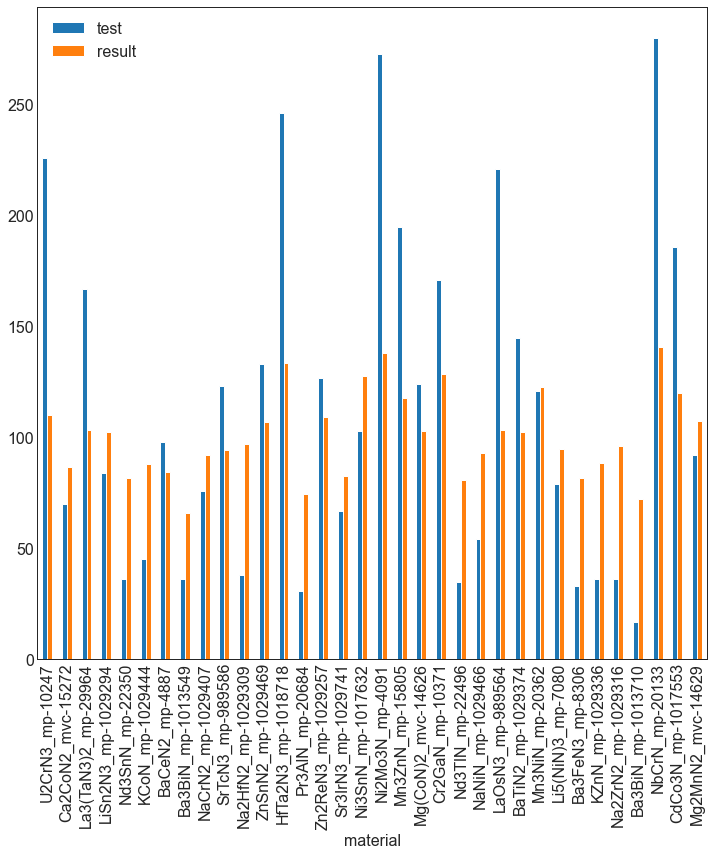

In [64]:
result_file = os.path.join(ROOT_DIR, "utils/test_results.csv")

df = pd.read_csv(result_file)
df.dropna(subset=['material'], inplace=True)
df.head()
df.plot(x="material", y=["test", "result"], kind='bar', figsize=(12, 12))